In [1]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("in colab?", IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive/")
    os.chdir('/content/drive/MyDrive/Denoise/cxr-experiment')
    !pwd # print current path
    # Install non-standard colab dependencies.
    !pip install torchinfo
    !pip install torchmetrics
    !pip install torchxrayvision
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import requests
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision.models as models
import time
from torchvision.io import read_image
from torch.utils.data import Dataset
import time
import datetime
import pickle
import os
import torchxrayvision as xrv

# after !pip install (in case of colab)
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
import torchinfo

from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader

torch.cuda.empty_cache()

# Select device
device = "str"#torch.device("cpu")
if torch.cuda.is_available():
    device = "cuda"#torch.device("cuda")
    torch.cuda.empty_cache()

print("Device: {}".format(device))

# util functions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


from oxr_utils import *

in colab? False


c:\Users\Morris\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchxrayvision\utils.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Device: cuda


In [2]:

if IN_COLAB:
    # USE THIS BLOCK COPIES THE NIH DATASET TO LOCAL COLAB INSTANCE AND IMPORTS THE NIH DATASET
    import zipfile
    import os
    from google.colab import drive
    drive.mount('/content/drive/')

    NIH_DATA_PATH = "/content/data/NIH_data"
    DRIVE_PATH = "/content/drive/MyDrive/Datasets"
    drive.mount('/content/drive/')

    zip_ref = zipfile.ZipFile(f"{DRIVE_PATH}/NIH_data.zip", 'r')
    if not os.path.exists(NIH_DATA_PATH):
      print("data path does not exist")
      zip_ref.extractall("/content/data") # can take 10-20min, but will make access very fast (30+ imgs/s)
      zip_ref.close()

    # Import NIH_Dataset class
    #NOTEBOOK_PATH = os.getcwd() # copy the dataset class file to the cwd
    #os.system(f"cp {DRIVE_PATH}/nih_dataset.py {NOTEBOOK_PATH}")

else: 
   NIH_DATA_PATH = "../data/NIH_data" # local path to the NIH dataset # Desktop

print("NIH_DATA_PATH: ", NIH_DATA_PATH)

NIH_DATA_PATH:  ../data/NIH_data


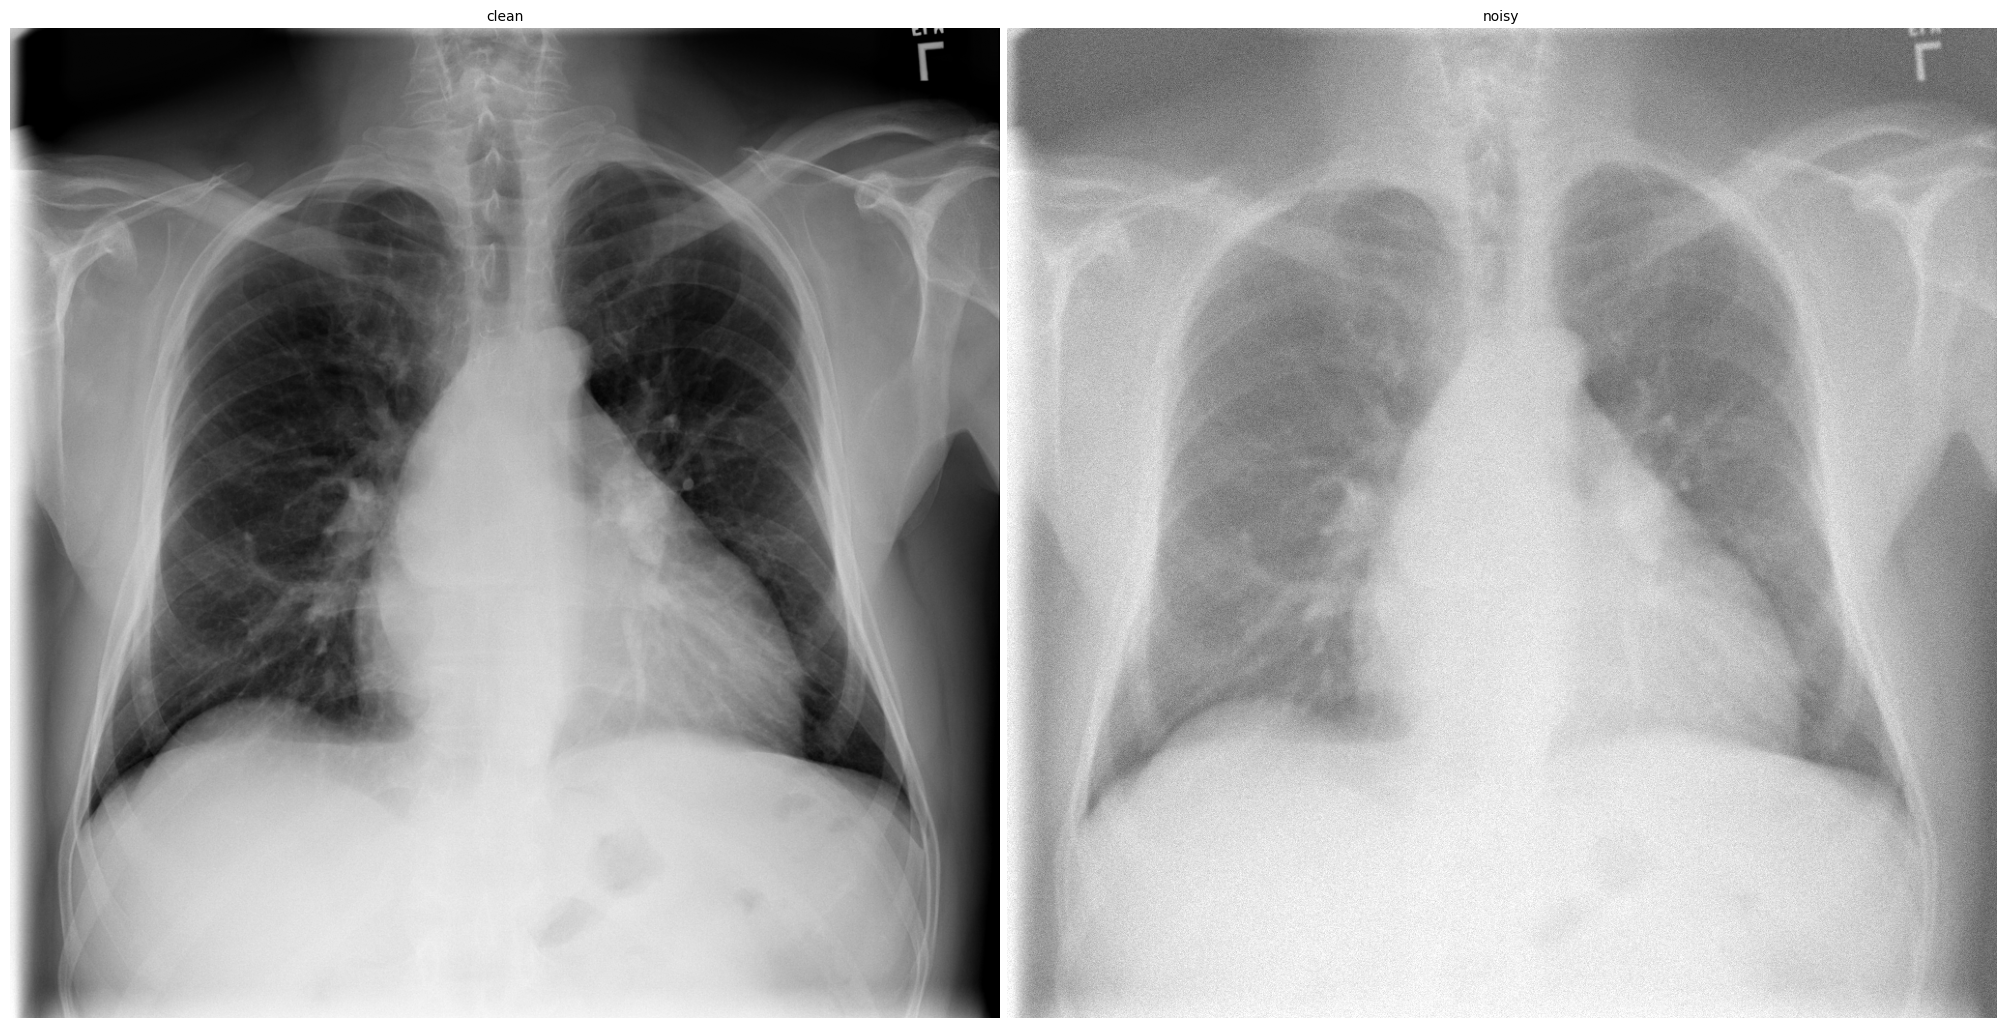

train/val/test: 32/8/8


In [3]:

DATA_PATH = NIH_DATA_PATH 
# DATA_PATH = "../data/NIH"

nih_train = NIH_Dataset(DATA_PATH, split="train")
nih_val = NIH_Dataset(DATA_PATH, split="val")
nih_test = NIH_Dataset(DATA_PATH, split="test")

LIMIT_DATA = None # For Using Full Dataset
LIMIT_DATA = [32, 8, 8] # For Testing

if LIMIT_DATA:
  nih_train = torch.utils.data.Subset(nih_train, range(LIMIT_DATA[0])) if LIMIT_DATA[0] else nih_train
  nih_val = torch.utils.data.Subset(nih_val, range(LIMIT_DATA[1])) if LIMIT_DATA[1] else nih_val
  nih_test = torch.utils.data.Subset(nih_test, range(LIMIT_DATA[2])) if LIMIT_DATA[2] else nih_test

BATCH_SIZE = 4

train_dl = DataLoader(nih_train, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)
val_dl = DataLoader(nih_val, batch_size=BATCH_SIZE)
test_dl = DataLoader(nih_test, batch_size=BATCH_SIZE)

NOISE_STRENGTH = 0.4
MIN_SIGNAL = 0.05

#NOISE_MOD = NoiseModule(NOISE_STRENGTH, MIN_SIGNAL).to(device)
NOISE_MOD = CameraApprox(1.0) #CameraDistort()

plot_cxr_images([nih_train[0][0][0], NOISE_MOD(nih_train[0][0])[0]], ["clean", "noisy"], figsize=(20, 40)) # show example
print(f"train/val/test: {len(nih_train)}/{len(nih_val)}/{len(nih_test)}")

In [11]:
# PATCH TRAINING CONFIGURATION
TRAINING_STEPS = [
    dict(patch_size=256, epochs=10, batch_size=32),
    dict(patch_size=512, epochs=5,  batch_size=8),
    dict(patch_size=1024, epochs=2, batch_size=2),
]

# Create one DataLoader per stage
training_step_dataloaders = [
    DataLoader(
        RandomPatchDataset(nih_train, patch_size=step["patch_size"]),
        batch_size=step["batch_size"],
        pin_memory=True,
        num_workers=4,
        prefetch_factor=2,
        drop_last=True
    )
    for step in TRAINING_STEPS
]

# Extract epochs and total epoch count
num_epochs = sum([step["epochs"] for step in TRAINING_STEPS])


In [12]:
# Load diagnosis model for evaluation
diagnosis_model = xrv.models.DenseNet(weights="densenet121-res224-nih")
diagnosis_model.to(device)
diagnosis_model.eval()

diagnosis_val_tester = NihTester(nih_val, device=device)
diagnosis_test_tester = NihTester(nih_test, device=device)

In [13]:
from oxr_utils.res_unet import ResUNet

model = ResUNet(s=4, k=64).to(device)
torchinfo.summary(model, (BATCH_SIZE,1,1024,1024))

Layer (type:depth-idx)                        Output Shape              Param #
ResUNet                                       [4, 1, 1024, 1024]        --
├─ModuleList: 1-1                             --                        --
│    └─EncoderStep: 2-1                       [4, 64, 512, 512]         --
│    │    └─DoubleConv: 3-1                   [4, 64, 1024, 1024]       37,824
│    │    └─MaxPool2d: 3-2                    [4, 64, 512, 512]         --
│    └─EncoderStep: 2-2                       [4, 128, 256, 256]        --
│    │    └─DoubleConv: 3-3                   [4, 128, 512, 512]        221,952
│    │    └─MaxPool2d: 3-4                    [4, 128, 256, 256]        --
│    └─EncoderStep: 2-3                       [4, 256, 128, 128]        --
│    │    └─DoubleConv: 3-5                   [4, 256, 256, 256]        886,272
│    │    └─MaxPool2d: 3-6                    [4, 256, 128, 128]        --
│    └─EncoderStep: 2-4                       [4, 512, 64, 64]          --
│    │


--- Training Step 1/3: patch_size=256, epochs=10, batch_size=32 ---


100%|██████████| 1/1 [00:27<00:00, 27.93s/it]


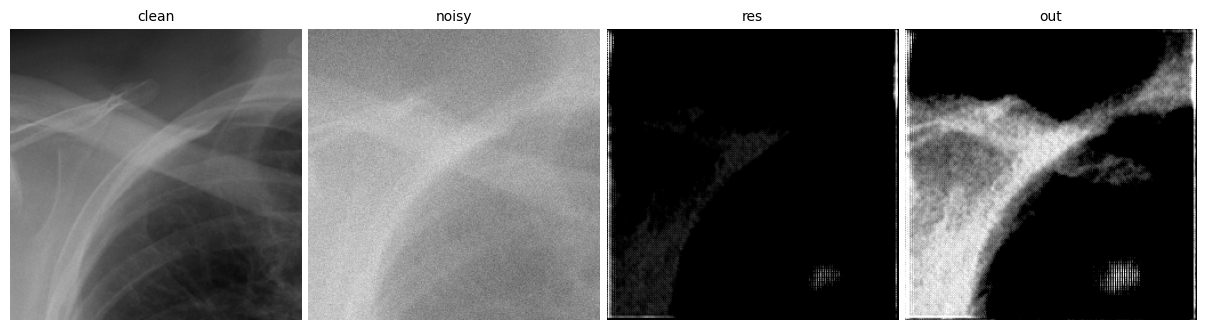

 50%|█████     | 1/2 [00:08<00:08,  8.82s/it]

metric value: 0.4439171850681305
metric value: 0.4439171850681305
metric value: 0.00746535137295723
metric value: 3.526980400085449
metric value: 0.6220404505729675


100%|██████████| 2/2 [00:17<00:00,  8.79s/it]

metric value: 0.4535277783870697
metric value: 0.4535277783870697
metric value: 0.012432719580829144
metric value: 3.4339609146118164
metric value: 0.6307517290115356
Epoch 0/17
validation loss: 0.2268
validation MSE: 0.2268
validation SSIM: 0.0062
validation PSNR: 1.7170
validation L1: 0.3154


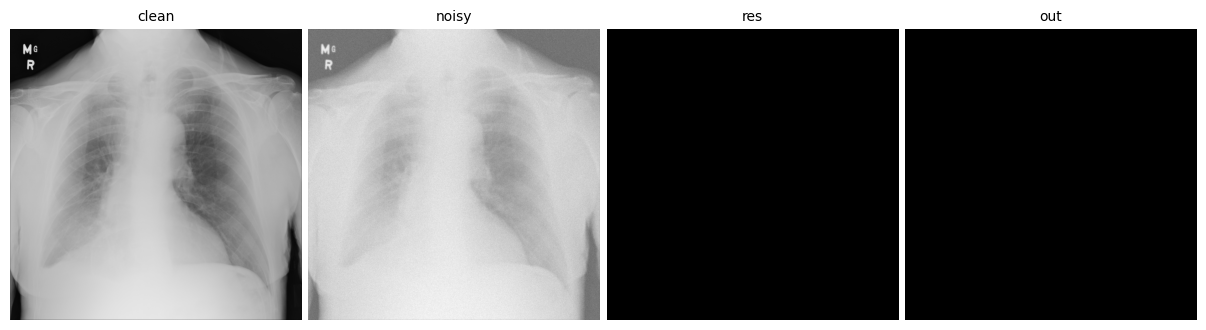

100%|██████████| 1/1 [00:30<00:00, 30.24s/it]


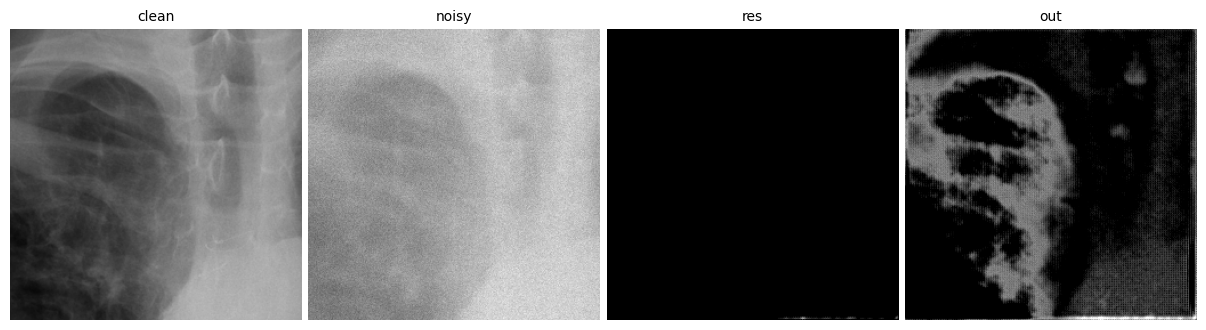

 50%|█████     | 1/2 [00:09<00:09,  9.63s/it]

metric value: 0.38288575410842896
metric value: 0.38288575410842896
metric value: 0.0033315543550997972
metric value: 4.169307708740234
metric value: 0.5610089898109436


100%|██████████| 2/2 [00:19<00:00,  9.51s/it]

metric value: 0.3881482183933258
metric value: 0.3881482183933258
metric value: 0.0031294922810047865
metric value: 4.110023498535156
metric value: 0.5653722286224365
Epoch 1/17
validation loss: 0.1941
validation MSE: 0.1941
validation SSIM: 0.0016
validation PSNR: 2.0550
validation L1: 0.2827


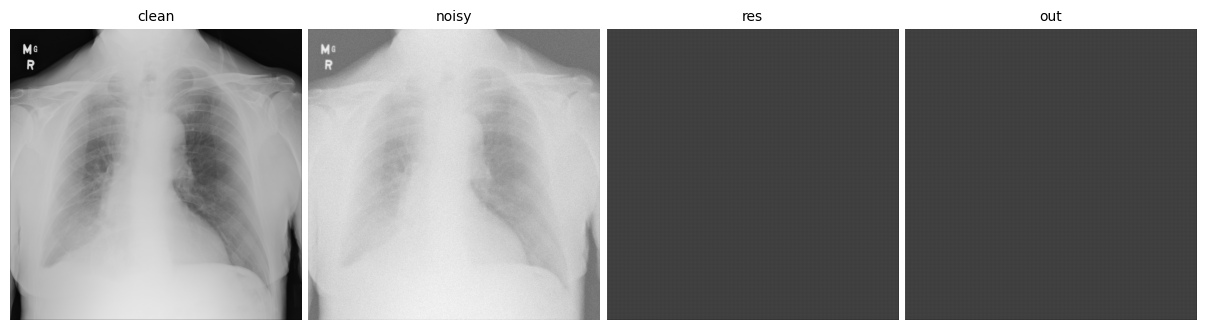

100%|██████████| 1/1 [00:30<00:00, 30.20s/it]


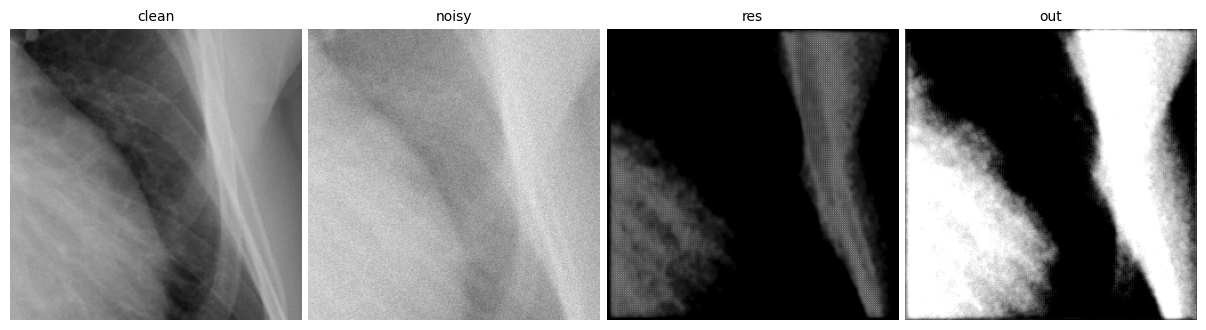

 50%|█████     | 1/2 [00:09<00:09,  9.72s/it]

metric value: 0.4439171850681305
metric value: 0.4439171850681305
metric value: 0.00746535137295723
metric value: 3.526980400085449
metric value: 0.6220404505729675


100%|██████████| 2/2 [00:19<00:00,  9.54s/it]

metric value: 0.4535277783870697
metric value: 0.4535277783870697
metric value: 0.012432719580829144
metric value: 3.4339609146118164
metric value: 0.6307517290115356
Epoch 2/17
validation loss: 0.2268
validation MSE: 0.2268
validation SSIM: 0.0062
validation PSNR: 1.7170
validation L1: 0.3154


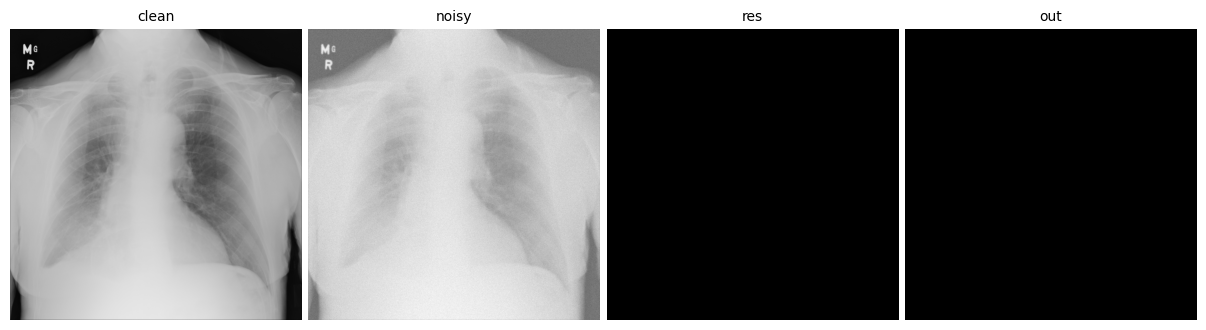

100%|██████████| 1/1 [00:31<00:00, 31.10s/it]


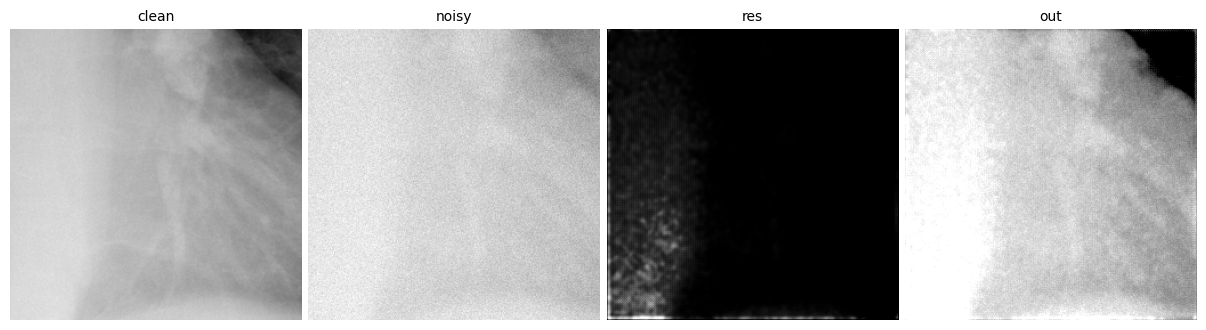

 50%|█████     | 1/2 [00:09<00:09,  9.46s/it]

metric value: 0.4439171850681305
metric value: 0.4439171850681305
metric value: 0.00746535137295723
metric value: 3.526980400085449
metric value: 0.6220404505729675


100%|██████████| 2/2 [00:18<00:00,  9.48s/it]

metric value: 0.4535277783870697
metric value: 0.4535277783870697
metric value: 0.012432719580829144
metric value: 3.4339609146118164
metric value: 0.6307517290115356
Epoch 3/17
validation loss: 0.2268
validation MSE: 0.2268
validation SSIM: 0.0062
validation PSNR: 1.7170
validation L1: 0.3154


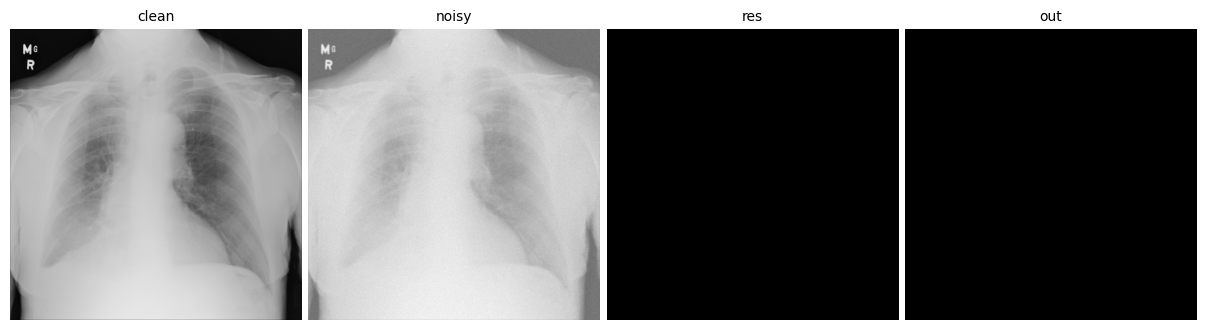

100%|██████████| 1/1 [00:30<00:00, 30.41s/it]


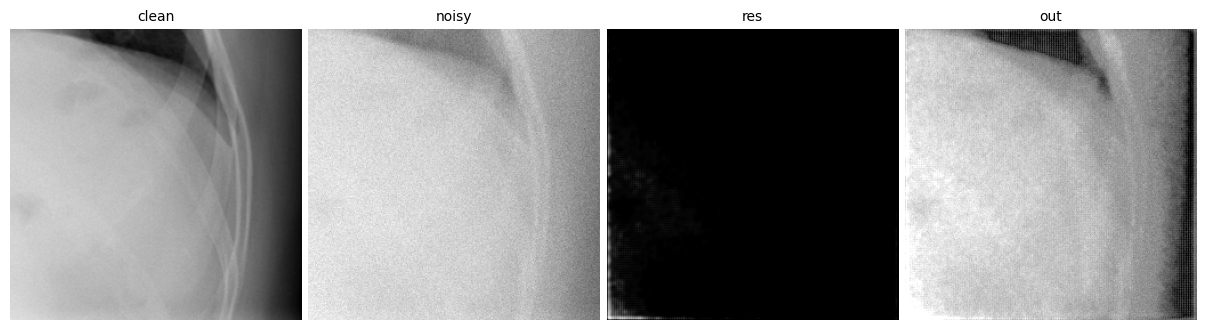

 50%|█████     | 1/2 [00:07<00:07,  7.24s/it]

metric value: 0.44485265016555786
metric value: 0.44485265016555786
metric value: 0.0064835501834750175
metric value: 3.5178380012512207
metric value: 0.6229759454727173


100%|██████████| 2/2 [00:16<00:00,  8.36s/it]

metric value: 0.4548256993293762
metric value: 0.4548256993293762
metric value: 0.0038885383401066065
metric value: 3.4215500354766846
metric value: 0.6320496797561646
Epoch 4/17
validation loss: 0.2274
validation MSE: 0.2274
validation SSIM: 0.0019
validation PSNR: 1.7108
validation L1: 0.3160


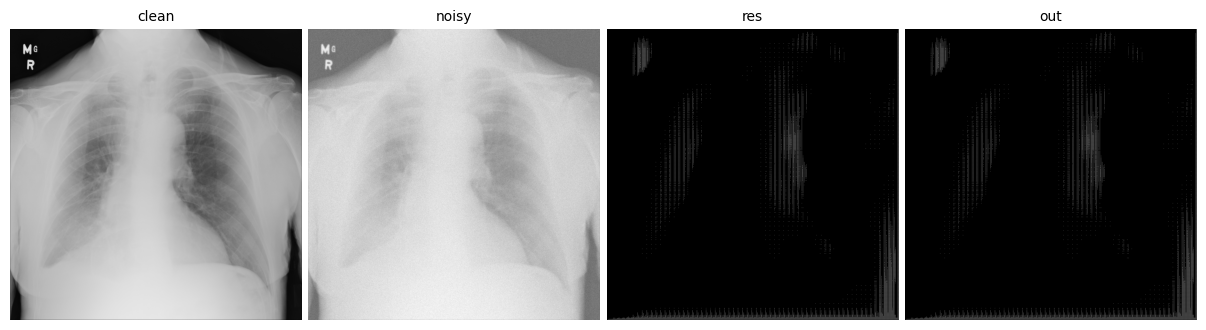

100%|██████████| 1/1 [00:30<00:00, 30.46s/it]


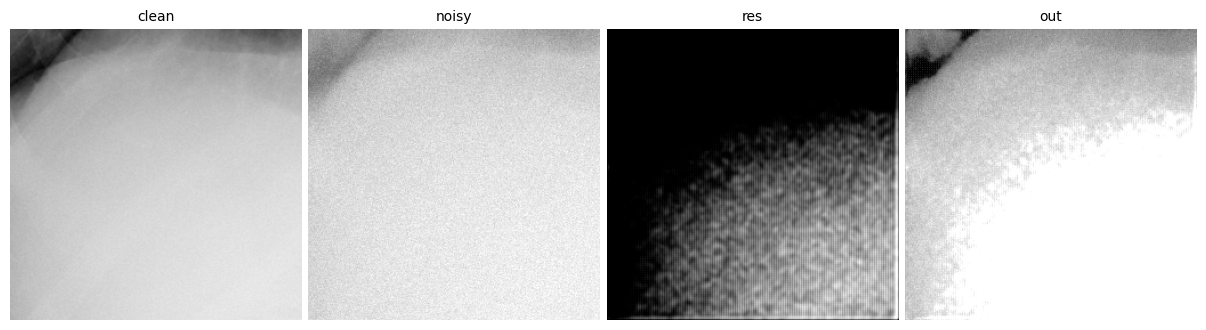

 50%|█████     | 1/2 [00:09<00:09,  9.37s/it]

metric value: 0.3218781650066376
metric value: 0.3218781650066376
metric value: 0.003144620917737484
metric value: 4.923084259033203
metric value: 0.5000014305114746


100%|██████████| 2/2 [00:18<00:00,  9.30s/it]

metric value: 0.32277658581733704
metric value: 0.32277658581733704
metric value: 0.0031171729788184166
metric value: 4.910979747772217
metric value: 0.500000536441803
Epoch 5/17
validation loss: 0.1614
validation MSE: 0.1614
validation SSIM: 0.0016
validation PSNR: 2.4555
validation L1: 0.2500


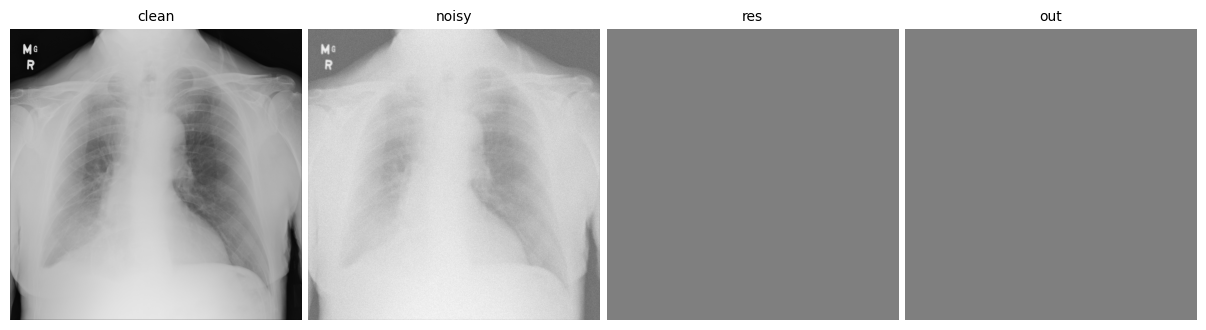

100%|██████████| 1/1 [00:29<00:00, 29.89s/it]


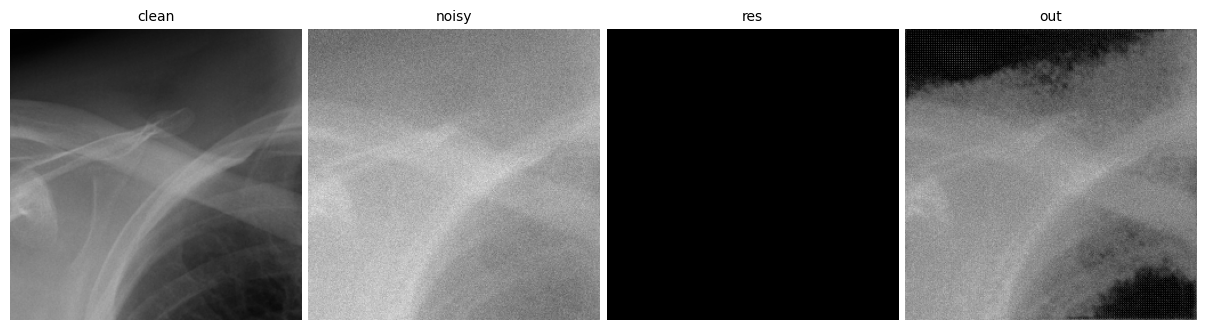

 50%|█████     | 1/2 [00:06<00:06,  6.76s/it]

metric value: 0.3218781650066376
metric value: 0.3218781650066376
metric value: 0.003144620917737484
metric value: 4.923084259033203
metric value: 0.5000014305114746


100%|██████████| 2/2 [00:15<00:00,  7.73s/it]

metric value: 0.32277658581733704
metric value: 0.32277658581733704
metric value: 0.0031171729788184166
metric value: 4.910979747772217
metric value: 0.500000536441803
Epoch 6/17
validation loss: 0.1614
validation MSE: 0.1614
validation SSIM: 0.0016
validation PSNR: 2.4555
validation L1: 0.2500


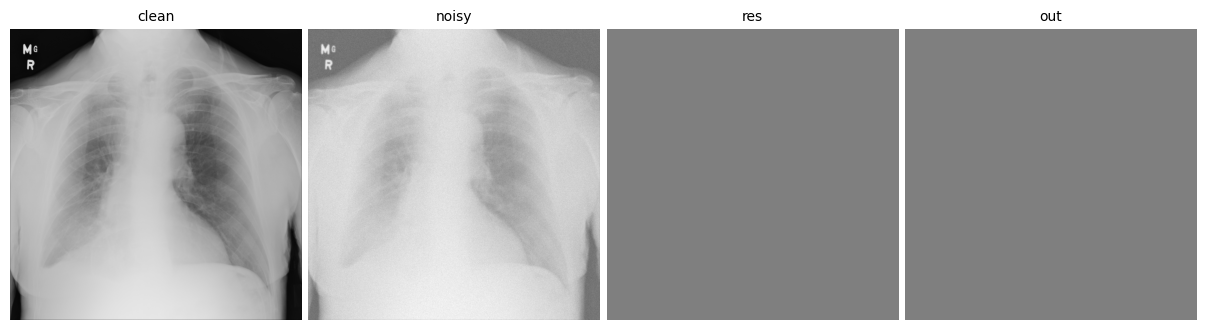

100%|██████████| 1/1 [00:29<00:00, 29.38s/it]


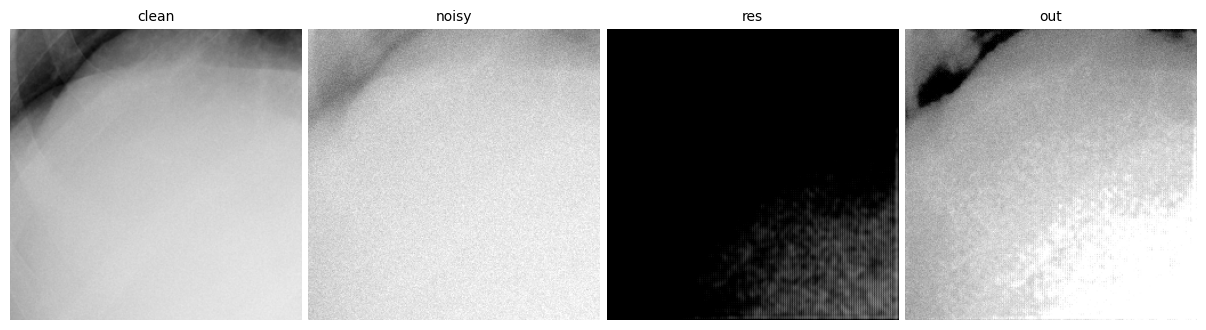

 50%|█████     | 1/2 [00:08<00:08,  8.91s/it]

metric value: 0.38290801644325256
metric value: 0.38290801644325256
metric value: 0.003069772617891431
metric value: 4.169054985046387
metric value: 0.5610312819480896


100%|██████████| 2/2 [00:18<00:00,  9.04s/it]

metric value: 0.3883139491081238
metric value: 0.3883139491081238
metric value: 0.0026273909024894238
metric value: 4.1081695556640625
metric value: 0.5655378699302673
Epoch 7/17
validation loss: 0.1942
validation MSE: 0.1942
validation SSIM: 0.0013
validation PSNR: 2.0541
validation L1: 0.2828


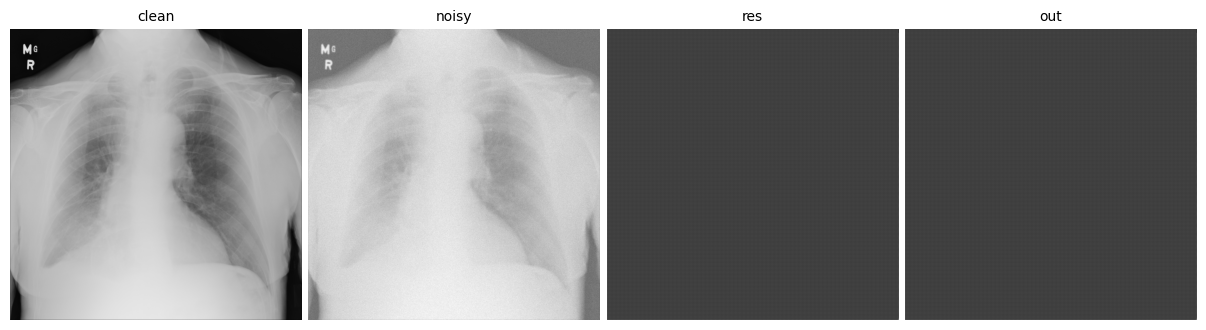

100%|██████████| 1/1 [00:31<00:00, 31.36s/it]


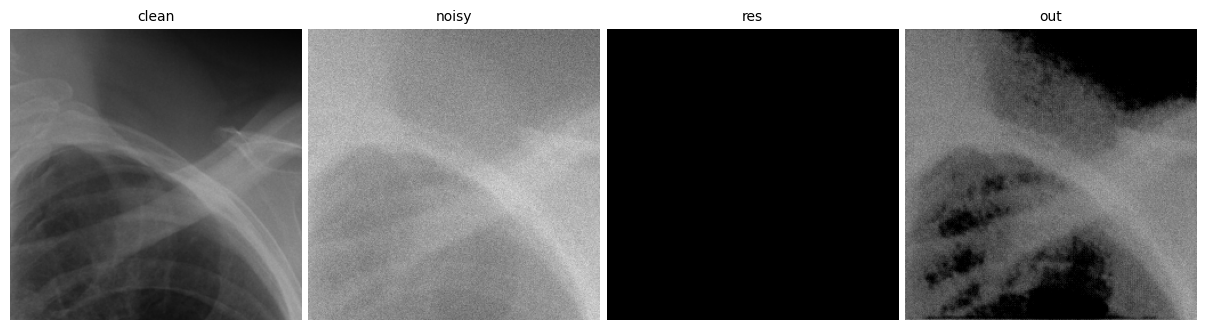

 50%|█████     | 1/2 [00:07<00:07,  7.58s/it]

metric value: 0.3827992081642151
metric value: 0.3827992081642151
metric value: 0.0031932510901242495
metric value: 4.170289516448975
metric value: 0.5609225034713745


100%|██████████| 2/2 [00:17<00:00,  8.70s/it]

metric value: 0.3881528973579407
metric value: 0.3881528973579407
metric value: 0.002734742360189557
metric value: 4.109971523284912
metric value: 0.565376877784729
Epoch 8/17
validation loss: 0.1941
validation MSE: 0.1941
validation SSIM: 0.0014
validation PSNR: 2.0550
validation L1: 0.2827


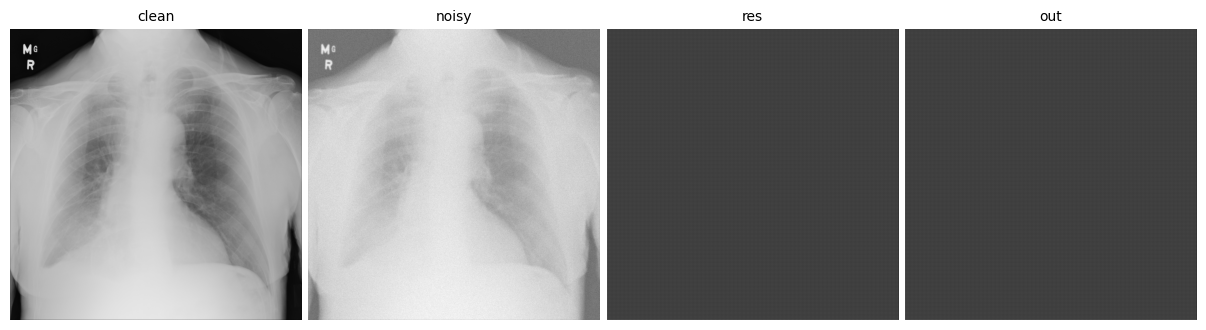

100%|██████████| 1/1 [00:30<00:00, 30.20s/it]


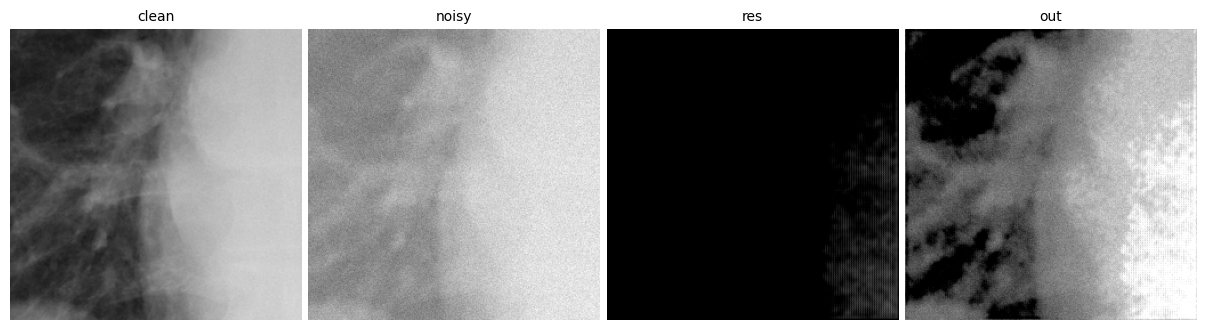

 50%|█████     | 1/2 [00:08<00:08,  8.99s/it]

metric value: 0.44354256987571716
metric value: 0.44354256987571716
metric value: 0.007052308414131403
metric value: 3.530646800994873
metric value: 0.6216655969619751


100%|██████████| 2/2 [00:17<00:00,  8.99s/it]

metric value: 0.4534502327442169
metric value: 0.4534502327442169
metric value: 0.010575901716947556
metric value: 3.4347035884857178
metric value: 0.6306742429733276
Epoch 9/17
validation loss: 0.2267
validation MSE: 0.2267
validation SSIM: 0.0053
validation PSNR: 1.7174
validation L1: 0.3153


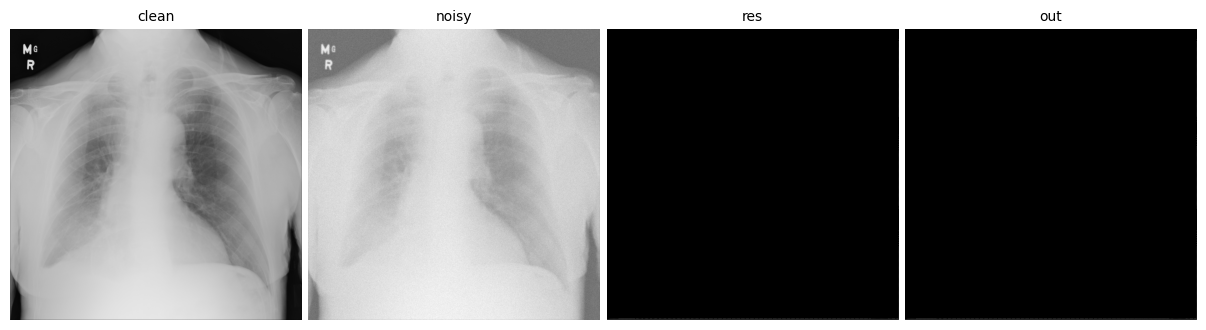


--- Training Step 2/3: patch_size=512, epochs=5, batch_size=8 ---


100%|██████████| 4/4 [02:18<00:00, 34.75s/it]


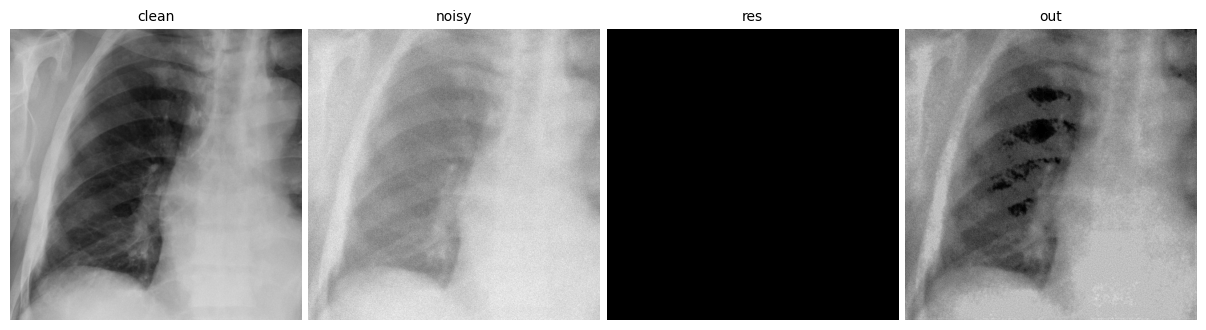

 50%|█████     | 1/2 [00:13<00:13, 13.39s/it]

metric value: 0.4439171850681305
metric value: 0.4439171850681305
metric value: 0.00746535137295723
metric value: 3.526980400085449
metric value: 0.6220404505729675


100%|██████████| 2/2 [00:26<00:00, 13.31s/it]

metric value: 0.45352745056152344
metric value: 0.45352745056152344
metric value: 0.012432129122316837
metric value: 3.4339640140533447
metric value: 0.6307511329650879
Epoch 10/17
validation loss: 0.2268
validation MSE: 0.2268
validation SSIM: 0.0062
validation PSNR: 1.7170
validation L1: 0.3154


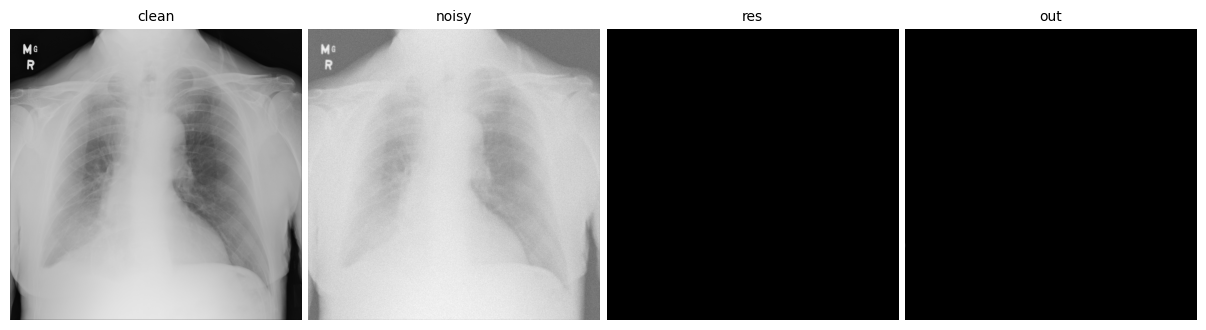

  0%|          | 0/4 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [15]:
torch.cuda.empty_cache()

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

start_time = last_epoch_time = time.time()

# --- Logging ---
train_loss_hist = []
val_loss_hist = []

log_metrics = {
    "loss": loss_function.to(device),
    "MSE": nn.MSELoss().to(device),
    "SSIM": StructuralSimilarityIndexMeasure(data_range=1.0).to(device),
    "PSNR": PeakSignalNoiseRatio(data_range=1.0).to(device),
    "L1": nn.L1Loss().to(device),
}

metrics_hist = []

# --- Training Loop with Patch Stages ---
global_epoch = 0
for step_idx, (step, train_dl) in enumerate(zip(TRAINING_STEPS, training_step_dataloaders)):
    print(f"\n--- Training Step {step_idx + 1}/{len(TRAINING_STEPS)}: "
          f"patch_size={step['patch_size']}, epochs={step['epochs']}, batch_size={step['batch_size']} ---")
    
    for local_epoch in range(step["epochs"]):
        print(f"Train Epoch {global_epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_ssim = 0.0



        # --- Validation ---
        for i, (clean, _lbls) in enumerate(tqdm(train_dl)):
            optimizer.zero_grad()

            clean = clean.to(device)
            noisy = NOISE_MOD(clean).to(device)

            res = model(noisy)
            out = (noisy + res).clamp(0.0,1.0)
            
            loss = loss_function(out, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * noisy.size(0)

        train_loss /= len(train_dl.dataset)
        train_loss_hist.append(train_loss)
   
        plot_cxr_images(
            [clean[0], noisy[0], res[0], out[0]],
            ["clean", "noisy", "res", "out"]
        )

        plot_cxr_res([clean[0], noisy[0], res[0], out[0]])

        # --- Validation ---
        print(f"Val. Epoch {global_epoch + 1}/{num_epochs}")
        model.eval()
        val_loss = 0.0

        val_metrics = {}

        with torch.no_grad():
            for i, (clean, _lbls) in enumerate(tqdm(val_dl)):
               
                clean = clean.to(device)
                noisy = NOISE_MOD(clean).to(device)

                res = model(noisy)
                out = (noisy + res).clamp(0.0,1.0)
            
                loss = loss_function(out, clean)
                val_loss += loss.item() * noisy.size(0)
                
                for metric_name, metric in log_metrics.items():
                    metric_value = metric(out, clean).item()

                    val_metrics[metric_name] = metric_value * noisy.size(0)

            
            
            for metric_name, metric_value in log_metrics.items():
                val_metrics[metric_name] /= len(val_dl.dataset)
                print(f"validation {metric_name}: {val_metrics[metric_name]:.4f}")
                
            metrics_hist.append(copy.deepcopy(val_metrics))
            
            val_loss /= len(val_dl.dataset)
            val_loss_hist.append(val_loss)

            plot_cxr_images(
                [clean[0], noisy[0], res[0], out[0]],
                ["clean", "noisy", "res", "out"]
            )

            torch.save({
                'epoch': global_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
            }, f"models/checkpoints/checkpoint_epoch_{global_epoch}.pth")

        global_epoch += 1

In [ ]:
# --- Plotting ---
epochs = list(range(1, num_epochs + 1))
val_epochs = [i + 1 for i in val_epoch_idxs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_hist, "b-o", label="Train Loss")
plt.plot(val_epochs, val_loss_hist, "r-o", label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_epochs, val_ssim_hist, "g-o", label="Val SSIM")
plt.title("SSIM over Epochs (Validation)")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_epochs, val_diag_auc_hist, "m-o", label="Diagnosis Diff")

plt.axhline(y=noisy_auc, color='r', linestyle='--', label="Noisy AUC")
plt.axhline(y=clean_auc, color='b', linestyle='--', label="Clean AUC")

plt.title("Diagnosis Difference over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Diagnosis AUC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()


In [ ]:
# --- Final Test Evaluation ---
model.eval()
test_loss = 0.0
test_ssim_score = 0.0

with torch.no_grad():
    for (clean, _lbls) in tqdm(test_dl, desc="Final Test Evaluation"):
        clean = clean.to(device)
        noisy = NOISE_MOD(clean).to(device)

        outputs = model(noisy)
        test_loss += loss_function(outputs, clean).item() * noisy.size(0)
        test_ssim_score += ssim(outputs, clean).item() * noisy.size(0)

test_loss /= len(test_dl.dataset)
test_ssim_score /= len(test_dl.dataset)

diagnosis_val_tester.gather_outputs_labels_module(NOISE_MOD)
test_noisy_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

diagnosis_val_tester.gather_outputs_labels_module(nn.Identity())
test_clean_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

diagnosis_val_tester.gather_outputs_labels_module(MedianFilter(device))
test_median_filter_auc = diagnosis_val_tester.avg_diagnosis_auc(use_cache=True)

noise_denoise_module = nn.Sequential(NOISE_MOD, model)
diagnosis_val_tester.gather_outputs_labels_module(noise_denoise_module)
test_avg_auc = diagnosis_val_tester.avg_diagnosis_auc()

print(f"""
--- Final Test Performance ---
Test Loss:         {test_loss:.4f}
Test SSIM:         {test_ssim_score:.4f}
Diagnosis Avg AUC:    {test_avg_auc:.4f} (noisy={test_noisy_auc:.4f}, clean={test_clean_auc:.4f}, median_filter={test_median_filter_auc:.4f})
""")

random_three_letters = "".join(np.random.choice(list("abcdefghijklmnopqrstuvwxyz"), 3))
torch.save(model.state_dict(), f"models/{model.name()}_{random_three_letters}.pth")

import json
from datetime import datetime

model_metadata = {
    "model_name": model.name(),
    "model_name_random_suffix": random_three_letters,
    "model_file_name": f"{model.name()}_{random_three_letters}.pth",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "architecture": "UNet",
    "s": model.s,
    "k": model.k,
    "num_parameters": sum(p.numel() for p in model.parameters()),
    "num_epochs": num_epochs,
    "num_train_images": len(train_dl.dataset),
    "val_loss": val_loss_hist[-1] if val_loss_hist else None,
    "val_ssim": val_ssim_hist[-1] if val_ssim_hist else None,
    "val_diag_diff": val_diag_auc_hist[-1] if val_diag_auc_hist else None,
    "test_loss": test_loss,
    "test_ssim": test_ssim_score,
    "test_diag_avg_auc": test_avg_auc
}

with open(f"models/{model.name()}_{random_three_letters}_meta.json", "w") as f:
    json.dump(model_metadata, f, indent=4)

torch.save({
    "model_state": model.state_dict(),
    "metadata": model_metadata
}, f"models/{model.name()}_{random_three_letters}_bundle.pth")

print(f"!saved model: '{model.name()}_{random_three_letters}'!")